## <font color='#636efa'>COVID-19 TracKer</font>

**Coronavirus Disease 2019 (COVID-19)** is a disease that was first identified in Wuhan, China, and later spread throughout the world. This project has 2 main purposes:
* Collect and publish the useful data required to understand the COVID-19 outbreak, especially in the United States. 
* For me to learn Dash, Plotly & several AWS Services

*The data is updated daily after 8 p.m. Pacific Time*

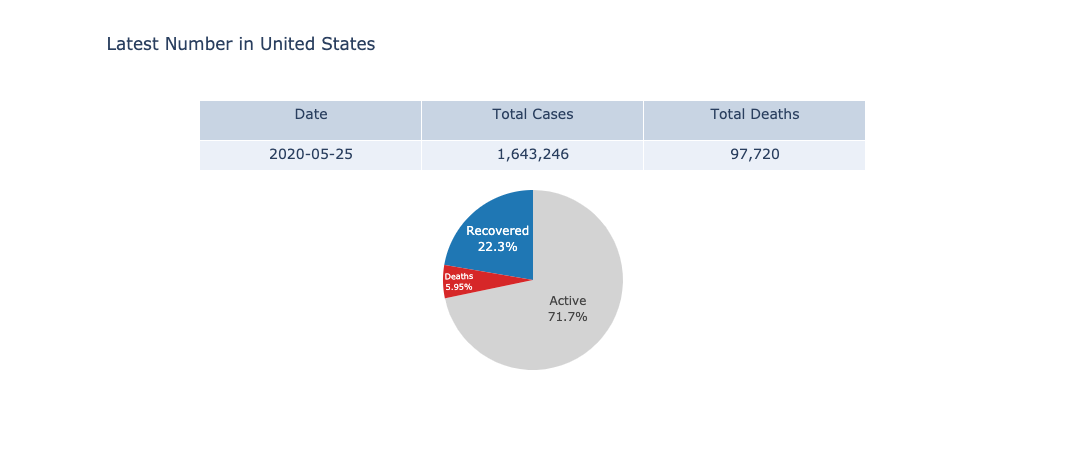

In [20]:
'''
COVID-19 TracKer project

Author: Tu Duong

Copyright © 2020 Tu Duong All Rights Reserved
'''

import os
import csv
import glob
import datetime
import subprocess
import urllib
import urllib.request
import urllib.error
import numpy                as np
import pandas               as pd
import plotly.graph_objects as go

import plotly.express       as px

from plotly.subplots import make_subplots
from datetime import date

from DataSource import *

import sys  

# load data into pandas data frame
ourworld_url = "https://covid.ourworldindata.org/data/ecdc/full_data.csv"

df = pd.read_csv(ourworld_url)

# convert 'date' column to the same data type for merging later
df['date']      = pd.to_datetime(df['date'])

us_covid19_data = df[ df['location']=='United States']


# load test data
covidtracking_url = 'https://covidtracking.com/api/v1/us/daily.csv'

jh_df = JohnHopkins(None).get_full_data()

us_covid19_test_data = CovidTracking(covidtracking_url).get_full_data()

condition = jh_df['Country_Region']=='US'
jh_us_data      = jh_df[condition]

last_update     = jh_us_data.Last_Update.sort_values(ascending=False).iloc[0]
total_confirmed = jh_us_data['Confirmed'].sum()
total_deaths    = jh_us_data['Deaths'].sum()
total_recovered = jh_us_data['Recovered'].sum()
total_active    = total_confirmed - (total_deaths + total_recovered)


latest_covid19_numbers = us_covid19_data.iloc[-1]
headers_dict = dict(values=['Date', 'Total Cases', 'Total Deaths'], 
                    font=dict(size=14),
                    height=40)

datetime_obj      = datetime.datetime.strptime(last_update, '%Y-%m-%d %H:%M:%S')
disp_date         = datetime_obj.strftime('%Y-%m-%d')
disp_total_case   = f'{total_confirmed:,}'
disp_total_deaths = f'{total_deaths:,}'

values_dict  = dict(values=[disp_date, disp_total_case, disp_total_deaths],
                    font_size=14,
                    height=30)

disp_table = go.Table(header=headers_dict, 
                      cells=values_dict
                     )

labels = ['Active', 'Deaths', 'Recovered']# get list of labels
values = [total_active, total_deaths, total_recovered]
colors = ['rgb(211, 211, 211)', 'rgb(214, 39, 40)', 'rgb(31, 119, 180)']
    
pie_disp = go.Pie(values=values, labels=labels, 
                  textposition='inside', 
                  textinfo='percent+label',
                  marker=dict(colors=colors)
                  )


fig1 = make_subplots(
    rows=3, cols=3,
    shared_xaxes=True, 
    vertical_spacing=0,
    horizontal_spacing=0,
    specs=[[{"type": "table", "colspan": 3}, None, None],
           [None, {"type": "pie", "rowspan": 2}, None],
           [None, None, None]]
)

fig1.add_trace(disp_table, row=1, col=1)
fig1.add_trace(pie_disp,   row=2, col=2)


fig1.update_layout(title={
                    'text': "Latest Number in United States",
                    'x':0.1}, 
                   showlegend=False, 
                   margin=dict(l=200, r=200, t=50)
                  )

fig1.show()

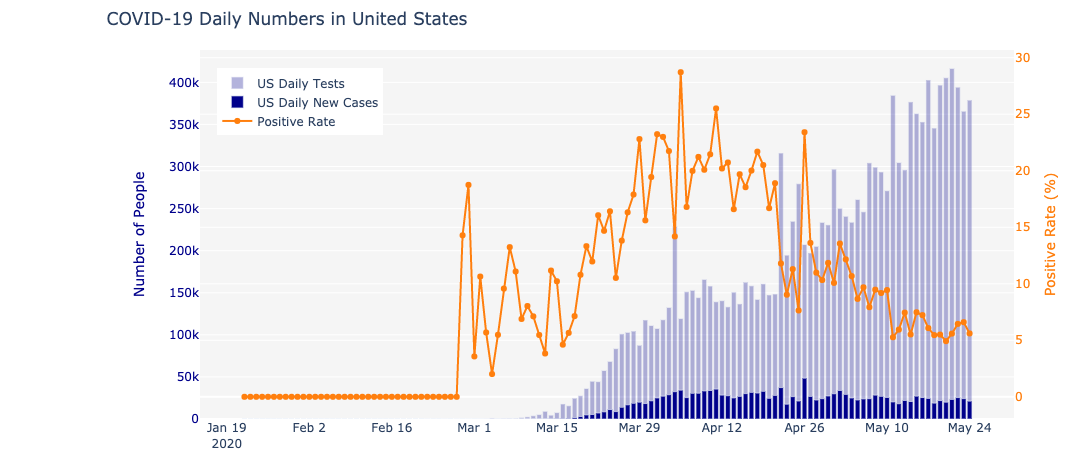

In [23]:
# merge 2 panda data frames into 1 data frame
merged_df = pd.merge(us_covid19_data,
                 us_covid19_test_data[['date', 'totalTestResultsIncrease']],
                 on='date')

# replace NaN with 0
merged_df = merged_df.fillna(0)

# generate 'positive_rate' column
merged_df['positive_rate'] = merged_df.apply(lambda row: (row.new_cases / row.totalTestResultsIncrease) * 100 if row.totalTestResultsIncrease else 0, axis = 1) 



fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(go.Bar(name='US Daily Tests',
                     x=merged_df.date,
                     y=merged_df.totalTestResultsIncrease,
                     marker_color='darkblue',
                     opacity=0.3))

fig.add_trace(go.Bar(name='US Daily New Cases',
                     x=merged_df.date,
                     y=merged_df.new_cases,
                     marker_color='darkblue'))

fig.add_trace(go.Scatter(name='Positive Rate',
                     x=merged_df.date,
                     y=merged_df.positive_rate,
                     mode='lines+markers',
                     marker_color='rgb(255, 127, 14)'),
             secondary_y="True")

fig.update_layout(
    title={
        'text': "COVID-19 Daily Numbers in United States",
        'x':0.1},
    barmode='overlay', 
    plot_bgcolor='rgb(245,245,245)',
    legend=dict(
        x=0.02,
        y=0.95),
    margin=dict(l=200, r=0, b=0, t=50)
)

fig.update_yaxes(title_text='Number of People', color='darkblue', secondary_y=False)
fig.update_yaxes(title_text='Positive Rate (%)', color='rgb(255, 127, 14)', secondary_y=True)

fig.show()


### About the data
Our COVID-19 dataset is a collection of these data sources:
* John Hopkins University (https://coronavirus.jhu.edu)
* Our World in Data (https://covid.ourworldindata.org)
* The Covid Tracking Project (https://covidtracking.com)

<div align="center">Copyright © 2020 Tu Duong. All Rights Reserved</div>